# Time series forecasting using Radial basis function network ( regression)

Data structure: 
- ID: Product Identifier
- DATEOP: Date Operation (weekly)
- NBRE: Sales/Demands count/quantity

Goal n°1: one-month-ahead forecasting of each product

Goal n°2: 4-month-ahead forecasting of each product.

"Product" refers to an anonymous banking product.


In [1]:
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from pandas import DataFrame
from pandas import concat
from matplotlib.pylab import rcParams
from collections import defaultdict
from scipy.spatial import distance
from sklearn.cluster import KMeans
import numpy as np
from sklearn.neural_network import MLPRegressor
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,LSTM
from keras.optimizers import SGD
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import optimizers 


Using TensorFlow backend.


In [2]:
path=r'C:/Users/yesmi/Desktop/engineerinternship/btseries.txt'
data= pd.read_csv(path,sep=';')

In [3]:
data.head()

,ID,DATEOP,NBRE
0,9243015,30/11/2009,1
1,9243015,31/12/2009,0
2,9243015,31/01/2010,1
3,9243015,28/02/2010,0
4,9243015,31/03/2010,2


In [4]:
data.shape

(3346, 3)

In [5]:
data.dtypes

ID        object
DATEOP    object
NBRE       int64
dtype: object

In [6]:
# 63 products
data.ID.value_counts()

9.33E+15     147
BX7          147
ZZ103160     145
ZZ100767      95
ZZ101783      68
ZZ100639      68
ZZ101831      68
ZZ107182      68
9273121       67
ZZ100121      67
ZZ102536      66
ZZ101787      66
ZZ1050331     66
BX10          66
ZZ102485      66
ZZ102716      66
ZZ102130      66
ZZ100202      66
ZZ102253      66
ZZ103110      65
BX5           65
9243015       64
ZZ100761      64
ZZ103604      63
BG10          63
ZZ101365      63
ZZ107452      62
ZZ102254      62
BX15          62
ZZ1050235     62
            ... 
9283022       56
BG7           55
CBM60         54
ZZF1017       52
9283021       52
ZZ300758      52
9273011       51
BG5           47
ZZ508539      46
ZZ100594      46
9.32E+15      44
BX20          42
ZZ103950      41
ZZ300568      40
ZZ501250      38
ZZ8950        35
BS30          33
ZZ101824      30
ZZ100211      29
ZZ300676      28
ZZ100780      22
9273052       16
ZZ305027      11
9273051        6
9273031        5
ZZ502209       3
BX 25          3
ZZ502052      

In [4]:
data.ID=data.ID.astype('category')

In [5]:
from dateutil import parser
for i in range (data.shape[0]):
    data.DATEOP[i]=parser.parse(data.DATEOP[i])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
#184 dates
data.DATEOP.value_counts()

2010-10-31    56
2010-11-30    56
2010-12-31    55
2011-05-31    54
2011-03-31    53
2011-02-28    53
2011-04-30    53
2011-08-31    53
2011-10-31    53
2011-01-31    53
2011-06-30    53
2011-09-30    53
2011-07-31    53
2010-09-30    53
2011-11-30    52
2011-12-31    52
2012-02-29    52
2012-05-31    51
2010-07-31    51
2012-01-31    51
2012-08-31    51
2012-03-31    51
2012-12-31    51
2012-04-30    51
2012-06-30    51
2010-08-31    51
2012-11-30    51
2012-07-31    51
2012-09-30    50
2013-01-31    50
              ..
2004-09-30     4
2004-01-31     4
2003-08-31     4
2006-07-31     4
2009-01-31     4
2005-08-31     4
2003-12-31     4
2008-05-31     4
2003-10-31     4
2008-01-31     4
2007-05-31     4
2004-04-30     4
2008-06-30     4
2008-11-30     4
2007-07-31     4
2009-04-30     4
2005-09-30     4
2003-07-31     4
2005-10-31     4
2008-08-31     4
2003-06-30     4
2006-10-31     4
2006-09-30     4
2009-05-31     4
2006-03-31     4
2003-09-30     4
2008-02-29     4
2004-08-31    

In [10]:
data.dtypes

ID        category
DATEOP      object
NBRE         int64
dtype: object

# Convert a Time Series forecasting  to a Supervised Learning task

We have a multivariate time series data.
We are going to use one stop sliding window approach to predict one-month-ahead of each product.

In [6]:
#First transformation
dat=data.pivot_table(index='DATEOP',
                             columns='ID',
                             values='NBRE',
                             aggfunc='sum')

In [7]:
dat=pd.DataFrame(dat)
dat.shape

(148, 63)

In [13]:
dat

ID,9.32E+15,9.33E+15,9243015,9273011,9273021,9273031,9273051,9273052,9273121,9283021,...,ZZ300676,ZZ300758,ZZ305027,ZZ501250,ZZ502052,ZZ502209,ZZ508539,ZZ8950,ZZF1013,ZZF1017
DATEOP,,,,,,,,,,,,,,,,,,,,,
2003-01-31,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-02-28,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-03-31,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-04-30,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-31,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-06-30,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-07-31,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-08-31,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-09-30,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
Products=dat.columns
Products

CategoricalIndex(['9.32E+15', '9.33E+15', '9243015', '9273011', '9273021',
                  '9273031', '9273051', '9273052', '9273121', '9283021',
                  '9283022', 'BG10', 'BG5', 'BG7', 'BS30', 'BX 25', 'BX10',
                  'BX15', 'BX20', 'BX5', 'BX7', 'CBM', 'CBM60', 'ZZ100121',
                  'ZZ100202', 'ZZ100211', 'ZZ100594', 'ZZ100639', 'ZZ100761',
                  'ZZ100767', 'ZZ100780', 'ZZ101365', 'ZZ101783', 'ZZ101787',
                  'ZZ101824', 'ZZ101831', 'ZZ102130', 'ZZ102253', 'ZZ102254',
                  'ZZ102485', 'ZZ102536', 'ZZ102716', 'ZZ103110', 'ZZ103160',
                  'ZZ103604', 'ZZ103950', 'ZZ105007', 'ZZ1050235', 'ZZ1050331',
                  'ZZ107182', 'ZZ107208', 'ZZ107452', 'ZZ300568', 'ZZ300676',
                  'ZZ300758', 'ZZ305027', 'ZZ501250', 'ZZ502052', 'ZZ502209',
                  'ZZ508539', 'ZZ8950', 'ZZF1013', 'ZZF1017'],
                 categories=['9.32E+15', '9.33E+15', '9243015', '9273011', '9273021', '92

In [9]:
dat=dat.fillna(value=0)

In [10]:
#second transformation

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
 


In [17]:
import numpy as np
dat=np.array(dat)
dat

array([[  0.,   1.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ..., 
       [  0.,  35.,   3., ...,   0.,   0.,   0.],
       [  0.,  31.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [24]:
#we will be using the 10 final dates ( for each product) to predict the value of the next month
dt=series_to_supervised(dat,10,1)

In [25]:
dt.shape

(138, 693)

In [26]:
dt.head(20)

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var9(t-10),var10(t-10),...,var54(t),var55(t),var56(t),var57(t),var58(t),var59(t),var60(t),var61(t),var62(t),var63(t)
10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## RBFN implementation

In [12]:
# Gaussian function

def RBFunction(r, x,c ):
    return( np.exp(- (distance.euclidean(x, c))**2/r**2))

# Computing radial/spread
def radial (x,c ):
    r=[]
    for i in range (c.shape[0]):
        k=[]
        for j in range(x.shape[0]) :
            k.append(distance.euclidean(x.iloc[j,:], c[i])) 
        m=(sum(k)/len(k))
        r.append(m)
    return(r)

# compute the centers using Kmeans

def centers (data,n):
    kmeans = KMeans(n_clusters=n)
    a = kmeans.fit(data)
    return(kmeans.cluster_centers_)     

#Preparing the RBF network

def RBF (centers,radials, X): 
    s=[[]for k in range (centers.shape[0])]
    
    for i in range (centers.shape[0]):
        for j in range (X.shape[0]):
            X=pd.DataFrame(X)
            s[i] .append(RBFunction(radials[i] ,X.iloc[j,:],centers[i]))
    s=pd.DataFrame(s)
    return(s.transpose()) 


## Evaluation function

In [13]:
# function to evaluate the performance of the models
def evaluate(y,pred):
    #MAPE:Mean absolute percentage error
    def MAPE(y,pred):
        mapev=[]
        aux1=y.reset_index(drop=True)
        aux1=pd.Series(aux1)
        aux2=pd.Series(pred)

        for i in aux1.index:
            if aux1[i]==0:
                mapev.append(0)
            else:
                mapev.append(abs(aux1[i]-aux2[i])/aux1[i])

        mape=(np.mean(mapev))*100
        return(mape)

#MAD:Mean absolute deviation
    def MAD_MSD(y,pred):
        madv=[]
        mapev=[]
        aux1=y.reset_index(drop=True)
        aux1=pd.Series(aux1)
        aux2=pd.Series(pred)
        for i in aux1.index:
            if aux1[i]==0:
                mapev.append(0)
            else:
                mapev.append(abs(aux1[i]-aux2[i])/aux1[i])
        for i in aux1.index:
            if aux1[i]!=0:
               madv.append(mapev[i]*aux1[i])
            else:
               madv.append(0)
        mad=np.mean(madv)
        #MSD:Mean squared deviation
        msdv=np.square(madv)
        msd=np.mean(msdv)
        return(mad,msd)

#SMAPE:Symmetric mean absolute percentage error
    def SMAPE(y,pred):
       smapev=[]
       smape=0
       aux1=y.reset_index(drop=True)
       aux1=pd.Series(aux1)
       aux2=pd.Series(pred)
       for i in aux1.index:
           if aux1[i]==0:
              smapev.append(0)
           else:
               smapev.append(2*(abs(aux1[i]-aux2[i])/((abs(aux1[i])+abs(aux2[i])))))

       smape = (np.mean(smapev))*100
       return(smape)
    MAPE=MAPE(y,pred)
    MAD,MSD=MAD_MSD(y,pred)
    SMAPE=SMAPE(y,pred)
    nn=['MAPE','MAD','MSD','SMAPE']
    kk=[MAPE,MAD,MSD,SMAPE]
    eva=pd.DataFrame([nn,kk])
    return(kk)
    

# Applying RBFN to predict the value of the first product

An example to validate the model

In [27]:
X_train, X_test, y_train, y_test = train_test_split( dt.loc[:,'var1(t-10)':'var63(t-1)'] , dt.loc[:,'var1(t)':'var63(t)'] , test_size=0.30, random_state=42)

In [28]:
y_train.shape

(96, 63)

In [29]:
y_test.shape

(42, 63)

In [30]:
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)

In [31]:
y_train.columns=Products
y_test.columns=Products

In [32]:
#neural network initialization
# Hyperparameter: number of centers/units of the hidden layer nc
nc=80
#Train
c=centers(X_train , nc)
r=radial(X_train,c)
inputs_train= pd.DataFrame(RBF(c,r,X_train))

#Test
inputs_t= pd.DataFrame(RBF(c,r,X_test))

## Starting with linear regression

In [32]:
#linear model
from sklearn import linear_model
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
mr=regr.fit(X_train, y_train.iloc[:,0])

# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [33]:
#Test
var=explained_variance_score(y_test.iloc[:,0], y_pred) 
mae=mean_absolute_error(y_test.iloc[:,0], y_pred)
mse=mean_squared_error(y_test.iloc[:,0], y_pred)
rmse=np.sqrt(mse)
r2=r2_score(y_test.iloc[:,0], y_pred )  
metric=[var,mae,mse,rmse,r2]
nn=['Explained variance','MAE','MSE','RMSE','R^2']
performance=pd.DataFrame([nn,metric])
performance

,0,1,2,3,4
0,Explained variance,MAE,MSE,RMSE,R^2
1,-4.79943e+21,1.57526e+11,9.47156e+22,3.07759e+11,-4.83878e+21


In [34]:
eval1=evaluate( y_test.iloc[:,0],y_pred)
eval1

,0,1,2,3
0,MAPE,MAD,MSD,SMAPE
1,9.4226e+11,5.74291e+10,3.7741e+22,38.0952


## Using Sklearn package (MLPRegressor) to implement the second part of the RBFNetwork

In [33]:
m=MLPRegressor(activation='identity',alpha=0.05,learning_rate ='adaptive',verbose=False)

In [34]:
mod=m.fit(inputs_train,y_train.iloc[:,0])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [35]:
#Train
out=m.predict(inputs_train)
var=explained_variance_score(y_train.iloc[:,0], out) 
mae=mean_absolute_error(y_train.iloc[:,0], out)
mse=mean_squared_error(y_train.iloc[:,0], out)
rmse=np.sqrt(mse)
r2=r2_score(y_train.iloc[:,0], out ) 
#r2a=1-((1-r2)* (1000-1) /(1000-1-5)) 
nn=['Explained variance','MAE','MSE','RMSE','R^2']
metric=[var,mae,mse,rmse,r2]
performance=pd.DataFrame([nn,metric])
performance

,0,1,2,3,4
0,Explained variance,MAE,MSE,RMSE,R^2
1,0.785614,1.43968,5.5761,2.36138,0.785311


In [36]:
evaluate(y_train.iloc[:,0], out)

[18.365455115574445,
 0.80099599374392794,
 3.8776685401799806,
 14.419465816220514]

In [37]:
#Test
outt=m.predict(inputs_t)
var=explained_variance_score(y_test.iloc[:,0], outt) 
mae=mean_absolute_error(y_test.iloc[:,0], outt)
mse=mean_squared_error(y_test.iloc[:,0], outt)
rmse=np.sqrt(mse)
r2=r2_score(y_test.iloc[:,0], outt) 
#r2a=1-((1-r2)* (1000-1) /(1000-1-5)) 
nn=['Explained variance','MAE','MSE','RMSE','R^2']
metric=[var,mae,mse,rmse,r2]
performance=pd.DataFrame([nn,metric])
performance

,0,1,2,3,4
0,Explained variance,MAE,MSE,RMSE,R^2
1,0.565515,1.58569,8.50615,2.91653,0.565442


In [38]:
evaluate(y_test.iloc[:,0], outt)

[14.32116517729812,
 0.94364471694670249,
 6.6560491516458686,
 12.530814632439041]

## Using Kears package to implement the second part of the RBFNetwork

In [39]:
#def baseline_model():
    # create model
model = Sequential()
model.add(Dense(1, input_dim=nc, kernel_initializer='normal'))
    # Compile model
model.compile(loss='mean_squared_error', optimizer='sgd')

In [40]:


#data preparation
inputs_train_arr=np.array(inputs_train)
inputs_t_arr=np.array(inputs_t)
y_train_arr=np.array(y_train.iloc[:,0])
y_t_arr=np.array(y_test.iloc[:,0])

#train the model
model.fit(inputs_train_arr,y_train_arr, epochs=3000, batch_size=20,verbose=1)

Epoch 1/3000
96/96 [==============================] - 0s - loss: 28.3459     
Epoch 2/3000
96/96 [==============================] - 0s - loss: 26.3065     
Epoch 3/3000
96/96 [==============================] - 0s - loss: 25.4178     
Epoch 4/3000
96/96 [==============================] - 0s - loss: 24.8680     
Epoch 5/3000
96/96 [==============================] - 0s - loss: 24.4765    
Epoch 6/3000
96/96 [==============================] - 0s - loss: 24.1482     
Epoch 7/3000
96/96 [==============================] - 0s - loss: 24.0831     
Epoch 8/3000
96/96 [==============================] - 0s - loss: 23.8233     
Epoch 9/3000
96/96 [==============================] - 0s - loss: 23.7626     
Epoch 10/3000
96/96 [==============================] - 0s - loss: 23.4644     
Epoch 11/3000
96/96 [==============================] - 0s - loss: 23.3112     
Epoch 12/3000
96/96 [==============================] - 0s - loss: 23.1090     
Epoch 13/3000
96/96 [==============================] - 0s - lo

96/96 [==============================] - 0s - loss: 13.7722     
Epoch 105/3000
96/96 [==============================] - 0s - loss: 13.9890     
Epoch 106/3000
96/96 [==============================] - 0s - loss: 13.7821     
Epoch 107/3000
96/96 [==============================] - 0s - loss: 13.6959     
Epoch 108/3000
96/96 [==============================] - 0s - loss: 13.5393     
Epoch 109/3000
96/96 [==============================] - 0s - loss: 13.5827    
Epoch 110/3000
96/96 [==============================] - 0s - loss: 13.4273     
Epoch 111/3000
96/96 [==============================] - 0s - loss: 13.4222     
Epoch 112/3000
96/96 [==============================] - 0s - loss: 13.4371    
Epoch 113/3000
96/96 [==============================] - 0s - loss: 13.3055     
Epoch 114/3000
96/96 [==============================] - 0s - loss: 13.2932     
Epoch 115/3000
96/96 [==============================] - 0s - loss: 13.1355     
Epoch 116/3000
96/96 [==============================] - 0

96/96 [==============================] - 0s - loss: 9.4307      
Epoch 206/3000
96/96 [==============================] - 0s - loss: 9.5380      
Epoch 207/3000
96/96 [==============================] - 0s - loss: 9.3294      
Epoch 208/3000
96/96 [==============================] - 0s - loss: 9.2792     
Epoch 209/3000
96/96 [==============================] - 0s - loss: 9.2496      
Epoch 210/3000
96/96 [==============================] - 0s - loss: 9.2720      
Epoch 211/3000
96/96 [==============================] - 0s - loss: 9.3041     
Epoch 212/3000
96/96 [==============================] - 0s - loss: 9.1922     
Epoch 213/3000
96/96 [==============================] - 0s - loss: 9.2360      
Epoch 214/3000
96/96 [==============================] - 0s - loss: 9.0927     
Epoch 215/3000
96/96 [==============================] - 0s - loss: 9.1404     
Epoch 216/3000
96/96 [==============================] - 0s - loss: 9.1094      
Epoch 217/3000
96/96 [==============================] - 0s -

96/96 [==============================] - 0s - loss: 7.0695     
Epoch 308/3000
96/96 [==============================] - 0s - loss: 7.0656      
Epoch 309/3000
96/96 [==============================] - ETA: 0s - loss: 11.57 - 0s - loss: 7.0992      
Epoch 310/3000
96/96 [==============================] - 0s - loss: 7.0363      
Epoch 311/3000
96/96 [==============================] - 0s - loss: 6.9945     
Epoch 312/3000
96/96 [==============================] - 0s - loss: 7.0493     
Epoch 313/3000
96/96 [==============================] - 0s - loss: 6.9958     
Epoch 314/3000
96/96 [==============================] - 0s - loss: 6.9793      
Epoch 315/3000
96/96 [==============================] - 0s - loss: 6.9168     
Epoch 316/3000
96/96 [==============================] - 0s - loss: 6.8970     
Epoch 317/3000
96/96 [==============================] - 0s - loss: 6.9500     
Epoch 318/3000
96/96 [==============================] - 0s - loss: 6.9757     
Epoch 319/3000
96/96 [=================

96/96 [==============================] - 0s - loss: 5.7594     
Epoch 410/3000
96/96 [==============================] - 0s - loss: 5.8032     
Epoch 411/3000
96/96 [==============================] - 0s - loss: 5.7568     
Epoch 412/3000
96/96 [==============================] - 0s - loss: 5.7382     
Epoch 413/3000
96/96 [==============================] - 0s - loss: 5.7442     
Epoch 414/3000
96/96 [==============================] - 0s - loss: 5.6856     
Epoch 415/3000
96/96 [==============================] - 0s - loss: 5.7135     
Epoch 416/3000
96/96 [==============================] - 0s - loss: 5.6628     
Epoch 417/3000
96/96 [==============================] - 0s - loss: 5.6835     
Epoch 418/3000
96/96 [==============================] - 0s - loss: 5.6975     
Epoch 419/3000
96/96 [==============================] - 0s - loss: 5.6532     
Epoch 420/3000
96/96 [==============================] - 0s - loss: 5.7085     
Epoch 421/3000
96/96 [==============================] - 0s - loss: 

96/96 [==============================] - 0s - loss: 4.9950     
Epoch 513/3000
96/96 [==============================] - 0s - loss: 4.9066     
Epoch 514/3000
96/96 [==============================] - 0s - loss: 4.9685     
Epoch 515/3000
96/96 [==============================] - 0s - loss: 4.9387     
Epoch 516/3000
96/96 [==============================] - 0s - loss: 4.8836     
Epoch 517/3000
96/96 [==============================] - 0s - loss: 4.9309      
Epoch 518/3000
96/96 [==============================] - 0s - loss: 4.9052     
Epoch 519/3000
96/96 [==============================] - 0s - loss: 4.8930     
Epoch 520/3000
96/96 [==============================] - 0s - loss: 4.8787     
Epoch 521/3000
96/96 [==============================] - ETA: 0s - loss: 3.961 - 0s - loss: 4.8569     
Epoch 522/3000
96/96 [==============================] - 0s - loss: 4.8771     
Epoch 523/3000
96/96 [==============================] - 0s - loss: 4.8340     
Epoch 524/3000
96/96 [====================

96/96 [==============================] - 0s - loss: 4.3529     
Epoch 615/3000
96/96 [==============================] - 0s - loss: 4.3991     
Epoch 616/3000
96/96 [==============================] - 0s - loss: 4.3674     
Epoch 617/3000
96/96 [==============================] - 0s - loss: 4.3507     
Epoch 618/3000
96/96 [==============================] - 0s - loss: 4.3932     
Epoch 619/3000
96/96 [==============================] - 0s - loss: 4.3381     
Epoch 620/3000
96/96 [==============================] - 0s - loss: 4.3197     
Epoch 621/3000
96/96 [==============================] - 0s - loss: 4.3401     
Epoch 622/3000
96/96 [==============================] - 0s - loss: 4.3598     
Epoch 623/3000
96/96 [==============================] - 0s - loss: 4.3032     
Epoch 624/3000
96/96 [==============================] - 0s - loss: 4.3070     
Epoch 625/3000
96/96 [==============================] - 0s - loss: 4.3834     
Epoch 626/3000
96/96 [==============================] - 0s - loss: 

96/96 [==============================] - 0s - loss: 3.9588     
Epoch 717/3000
96/96 [==============================] - 0s - loss: 3.9973     
Epoch 718/3000
96/96 [==============================] - 0s - loss: 4.0098     
Epoch 719/3000
96/96 [==============================] - 0s - loss: 3.9859     
Epoch 720/3000
96/96 [==============================] - 0s - loss: 3.9588     
Epoch 721/3000
96/96 [==============================] - 0s - loss: 3.9650     
Epoch 722/3000
96/96 [==============================] - 0s - loss: 3.9402     
Epoch 723/3000
96/96 [==============================] - 0s - loss: 4.0158     
Epoch 724/3000
96/96 [==============================] - 0s - loss: 3.9247     
Epoch 725/3000
96/96 [==============================] - 0s - loss: 3.9627     
Epoch 726/3000
96/96 [==============================] - 0s - loss: 3.9215     
Epoch 727/3000
96/96 [==============================] - 0s - loss: 3.9208     
Epoch 728/3000
96/96 [==============================] - 0s - loss: 

96/96 [==============================] - 0s - loss: 3.6606     
Epoch 820/3000
96/96 [==============================] - 0s - loss: 3.6604     
Epoch 821/3000
96/96 [==============================] - 0s - loss: 3.6496     
Epoch 822/3000
96/96 [==============================] - 0s - loss: 3.6522     
Epoch 823/3000
96/96 [==============================] - 0s - loss: 3.6693     
Epoch 824/3000
96/96 [==============================] - 0s - loss: 3.6412     
Epoch 825/3000
96/96 [==============================] - 0s - loss: 3.6259     
Epoch 826/3000
96/96 [==============================] - 0s - loss: 3.6842     
Epoch 827/3000
96/96 [==============================] - 0s - loss: 3.6447     
Epoch 828/3000
96/96 [==============================] - 0s - loss: 3.6193     
Epoch 829/3000
96/96 [==============================] - 0s - loss: 3.6383     
Epoch 830/3000
96/96 [==============================] - 0s - loss: 3.6493     
Epoch 831/3000
96/96 [==============================] - 0s - loss: 

96/96 [==============================] - 0s - loss: 3.4764     
Epoch 923/3000
96/96 [==============================] - 0s - loss: 3.4173     
Epoch 924/3000
96/96 [==============================] - 0s - loss: 3.4187     
Epoch 925/3000
96/96 [==============================] - 0s - loss: 3.4608     
Epoch 926/3000
96/96 [==============================] - 0s - loss: 3.4263     
Epoch 927/3000
96/96 [==============================] - 0s - loss: 3.4291     
Epoch 928/3000
96/96 [==============================] - 0s - loss: 3.4114     
Epoch 929/3000
96/96 [==============================] - 0s - loss: 3.3828     
Epoch 930/3000
96/96 [==============================] - 0s - loss: 3.4110     
Epoch 931/3000
96/96 [==============================] - 0s - loss: 3.3763     
Epoch 932/3000
96/96 [==============================] - 0s - loss: 3.3798     
Epoch 933/3000
96/96 [==============================] - 0s - loss: 3.3885     
Epoch 934/3000
96/96 [==============================] - 0s - loss: 

96/96 [==============================] - 0s - loss: 3.2174     
Epoch 1024/3000
96/96 [==============================] - ETA: 0s - loss: 4.093 - 0s - loss: 3.2206     
Epoch 1025/3000
96/96 [==============================] - 0s - loss: 3.2479     
Epoch 1026/3000
96/96 [==============================] - 0s - loss: 3.2065     
Epoch 1027/3000
96/96 [==============================] - 0s - loss: 3.1867     
Epoch 1028/3000
96/96 [==============================] - 0s - loss: 3.1900     
Epoch 1029/3000
96/96 [==============================] - 0s - loss: 3.2113     
Epoch 1030/3000
96/96 [==============================] - 0s - loss: 3.2083     
Epoch 1031/3000
96/96 [==============================] - 0s - loss: 3.2364     
Epoch 1032/3000
96/96 [==============================] - 0s - loss: 3.1663     
Epoch 1033/3000
96/96 [==============================] - 0s - loss: 3.1867     
Epoch 1034/3000
96/96 [==============================] - 0s - loss: 3.2093     
Epoch 1035/3000
96/96 [=========

96/96 [==============================] - 0s - loss: 3.0575     
Epoch 1125/3000
96/96 [==============================] - 0s - loss: 3.0165     
Epoch 1126/3000
96/96 [==============================] - 0s - loss: 3.0523     
Epoch 1127/3000
96/96 [==============================] - 0s - loss: 3.0495     
Epoch 1128/3000
96/96 [==============================] - 0s - loss: 3.0041     
Epoch 1129/3000
96/96 [==============================] - 0s - loss: 3.0077     
Epoch 1130/3000
96/96 [==============================] - 0s - loss: 3.0146     
Epoch 1131/3000
96/96 [==============================] - ETA: 0s - loss: 3.998 - 0s - loss: 3.1024     
Epoch 1132/3000
96/96 [==============================] - 0s - loss: 2.9966     
Epoch 1133/3000
96/96 [==============================] - 0s - loss: 3.0373     
Epoch 1134/3000
96/96 [==============================] - 0s - loss: 2.9902     
Epoch 1135/3000
96/96 [==============================] - 0s - loss: 3.0075     
Epoch 1136/3000
96/96 [=========

96/96 [==============================] - 0s - loss: 2.8962     
Epoch 1226/3000
96/96 [==============================] - 0s - loss: 2.8599     
Epoch 1227/3000
96/96 [==============================] - 0s - loss: 2.8479     
Epoch 1228/3000
96/96 [==============================] - 0s - loss: 2.8507     
Epoch 1229/3000
96/96 [==============================] - 0s - loss: 2.8596     
Epoch 1230/3000
96/96 [==============================] - 0s - loss: 2.8603     
Epoch 1231/3000
96/96 [==============================] - 0s - loss: 2.8897     
Epoch 1232/3000
96/96 [==============================] - 0s - loss: 2.8688     
Epoch 1233/3000
96/96 [==============================] - 0s - loss: 2.8490     
Epoch 1234/3000
96/96 [==============================] - 0s - loss: 2.8657     
Epoch 1235/3000
96/96 [==============================] - 0s - loss: 2.8571     
Epoch 1236/3000
96/96 [==============================] - 0s - loss: 2.8548     
Epoch 1237/3000
96/96 [==============================] -

96/96 [==============================] - ETA: 0s - loss: 3.595 - 0s - loss: 2.7340     
Epoch 1328/3000
96/96 [==============================] - 0s - loss: 2.7183     
Epoch 1329/3000
96/96 [==============================] - 0s - loss: 2.7245     
Epoch 1330/3000
96/96 [==============================] - 0s - loss: 2.8443     
Epoch 1331/3000
96/96 [==============================] - 0s - loss: 2.7146     
Epoch 1332/3000
96/96 [==============================] - 0s - loss: 2.7234     
Epoch 1333/3000
96/96 [==============================] - 0s - loss: 2.7296     
Epoch 1334/3000
96/96 [==============================] - 0s - loss: 2.7186     
Epoch 1335/3000
96/96 [==============================] - 0s - loss: 2.7175     
Epoch 1336/3000
96/96 [==============================] - 0s - loss: 2.7210     
Epoch 1337/3000
96/96 [==============================] - 0s - loss: 2.7231     
Epoch 1338/3000
96/96 [==============================] - 0s - loss: 2.7038     
Epoch 1339/3000
96/96 [=========

96/96 [==============================] - ETA: 0s - loss: 2.875 - 0s - loss: 2.6032     
Epoch 1429/3000
96/96 [==============================] - 0s - loss: 2.5971     
Epoch 1430/3000
96/96 [==============================] - 0s - loss: 2.6456     
Epoch 1431/3000
96/96 [==============================] - 0s - loss: 2.5922     
Epoch 1432/3000
96/96 [==============================] - 0s - loss: 2.6111     
Epoch 1433/3000
96/96 [==============================] - 0s - loss: 2.6108     
Epoch 1434/3000
96/96 [==============================] - 0s - loss: 2.6102     
Epoch 1435/3000
96/96 [==============================] - 0s - loss: 2.6194     
Epoch 1436/3000
96/96 [==============================] - 0s - loss: 2.5941     
Epoch 1437/3000
96/96 [==============================] - 0s - loss: 2.5976     
Epoch 1438/3000
96/96 [==============================] - 0s - loss: 2.5823     
Epoch 1439/3000
96/96 [==============================] - 0s - loss: 2.5697     
Epoch 1440/3000
96/96 [=========

96/96 [==============================] - 0s - loss: 2.5073     
Epoch 1530/3000
96/96 [==============================] - 0s - loss: 2.4697     
Epoch 1531/3000
96/96 [==============================] - 0s - loss: 2.4747     
Epoch 1532/3000
96/96 [==============================] - 0s - loss: 2.4949     
Epoch 1533/3000
96/96 [==============================] - 0s - loss: 2.4598     
Epoch 1534/3000
96/96 [==============================] - 0s - loss: 2.4903     
Epoch 1535/3000
96/96 [==============================] - 0s - loss: 2.4772     
Epoch 1536/3000
96/96 [==============================] - 0s - loss: 2.4928     
Epoch 1537/3000
96/96 [==============================] - 0s - loss: 2.4815     
Epoch 1538/3000
96/96 [==============================] - 0s - loss: 2.4542     
Epoch 1539/3000
96/96 [==============================] - 0s - loss: 2.4769     
Epoch 1540/3000
96/96 [==============================] - 0s - loss: 2.4855     
Epoch 1541/3000
96/96 [==============================] -

96/96 [==============================] - 0s - loss: 2.3697     
Epoch 1631/3000
96/96 [==============================] - 0s - loss: 2.3842     
Epoch 1632/3000
96/96 [==============================] - 0s - loss: 2.3856     
Epoch 1633/3000
96/96 [==============================] - 0s - loss: 2.3885     
Epoch 1634/3000
96/96 [==============================] - 0s - loss: 2.3655     
Epoch 1635/3000
96/96 [==============================] - 0s - loss: 2.3599     
Epoch 1636/3000
96/96 [==============================] - 0s - loss: 2.3865     
Epoch 1637/3000
96/96 [==============================] - 0s - loss: 2.3955     
Epoch 1638/3000
96/96 [==============================] - 0s - loss: 2.3671     
Epoch 1639/3000
96/96 [==============================] - 0s - loss: 2.3666     
Epoch 1640/3000
96/96 [==============================] - 0s - loss: 2.3953     
Epoch 1641/3000
96/96 [==============================] - 0s - loss: 2.3480     
Epoch 1642/3000
96/96 [==============================] -

96/96 [==============================] - 0s - loss: 2.2616     
Epoch 1733/3000
96/96 [==============================] - 0s - loss: 2.2689     
Epoch 1734/3000
96/96 [==============================] - 0s - loss: 2.2603     
Epoch 1735/3000
96/96 [==============================] - 0s - loss: 2.2924     
Epoch 1736/3000
96/96 [==============================] - 0s - loss: 2.2608     
Epoch 1737/3000
96/96 [==============================] - 0s - loss: 2.2640     
Epoch 1738/3000
96/96 [==============================] - 0s - loss: 2.2743     
Epoch 1739/3000
96/96 [==============================] - 0s - loss: 2.2753     
Epoch 1740/3000
96/96 [==============================] - 0s - loss: 2.2757     
Epoch 1741/3000
96/96 [==============================] - 0s - loss: 2.2695     
Epoch 1742/3000
96/96 [==============================] - 0s - loss: 2.2510     
Epoch 1743/3000
96/96 [==============================] - 0s - loss: 2.2558     
Epoch 1744/3000
96/96 [==============================] -

96/96 [==============================] - 0s - loss: 2.1862     
Epoch 1833/3000
96/96 [==============================] - 0s - loss: 2.1801     
Epoch 1834/3000
96/96 [==============================] - 0s - loss: 2.1841     
Epoch 1835/3000
96/96 [==============================] - ETA: 0s - loss: 2.756 - 0s - loss: 2.2008     
Epoch 1836/3000
96/96 [==============================] - 0s - loss: 2.1857     
Epoch 1837/3000
96/96 [==============================] - 0s - loss: 2.2073     
Epoch 1838/3000
96/96 [==============================] - ETA: 0s - loss: 4.008 - 0s - loss: 2.1831     
Epoch 1839/3000
96/96 [==============================] - 0s - loss: 2.1731     
Epoch 1840/3000
96/96 [==============================] - 0s - loss: 2.1654     
Epoch 1841/3000
96/96 [==============================] - 0s - loss: 2.1647     
Epoch 1842/3000
96/96 [==============================] - 0s - loss: 2.2043     
Epoch 1843/3000
96/96 [==============================] - 0s - loss: 2.1954     
Epoch 18

96/96 [==============================] - 0s - loss: 2.1000     
Epoch 1934/3000
96/96 [==============================] - 0s - loss: 2.1200     
Epoch 1935/3000
96/96 [==============================] - 0s - loss: 2.0975     
Epoch 1936/3000
96/96 [==============================] - 0s - loss: 2.1298     
Epoch 1937/3000
96/96 [==============================] - 0s - loss: 2.1022     
Epoch 1938/3000
96/96 [==============================] - 0s - loss: 2.1023     
Epoch 1939/3000
96/96 [==============================] - 0s - loss: 2.1071     
Epoch 1940/3000
96/96 [==============================] - 0s - loss: 2.0943     
Epoch 1941/3000
96/96 [==============================] - 0s - loss: 2.0767     
Epoch 1942/3000
96/96 [==============================] - 0s - loss: 2.1395     
Epoch 1943/3000
96/96 [==============================] - 0s - loss: 2.0972     
Epoch 1944/3000
96/96 [==============================] - 0s - loss: 2.0849     
Epoch 1945/3000
96/96 [==============================] -

96/96 [==============================] - ETA: 0s - loss: 2.971 - 0s - loss: 2.0105     
Epoch 2036/3000
96/96 [==============================] - 0s - loss: 2.0089     
Epoch 2037/3000
96/96 [==============================] - 0s - loss: 2.0318     
Epoch 2038/3000
96/96 [==============================] - 0s - loss: 2.0048     
Epoch 2039/3000
96/96 [==============================] - 0s - loss: 2.0126     
Epoch 2040/3000
96/96 [==============================] - 0s - loss: 2.0335     
Epoch 2041/3000
96/96 [==============================] - 0s - loss: 1.9993     
Epoch 2042/3000
96/96 [==============================] - 0s - loss: 2.0240     
Epoch 2043/3000
96/96 [==============================] - 0s - loss: 1.9979     
Epoch 2044/3000
96/96 [==============================] - 0s - loss: 2.0003     
Epoch 2045/3000
96/96 [==============================] - 0s - loss: 2.0089     
Epoch 2046/3000
96/96 [==============================] - 0s - loss: 2.0091     
Epoch 2047/3000
96/96 [=========

96/96 [==============================] - 0s - loss: 1.9406     
Epoch 2137/3000
96/96 [==============================] - 0s - loss: 1.9417     
Epoch 2138/3000
96/96 [==============================] - 0s - loss: 1.9620     
Epoch 2139/3000
96/96 [==============================] - 0s - loss: 1.9522     
Epoch 2140/3000
96/96 [==============================] - ETA: 0s - loss: 2.486 - 0s - loss: 1.9396     
Epoch 2141/3000
96/96 [==============================] - 0s - loss: 1.9287     
Epoch 2142/3000
96/96 [==============================] - 0s - loss: 1.9307     
Epoch 2143/3000
96/96 [==============================] - 0s - loss: 1.9693     
Epoch 2144/3000
96/96 [==============================] - 0s - loss: 1.9508     
Epoch 2145/3000
96/96 [==============================] - 0s - loss: 1.9412     
Epoch 2146/3000
96/96 [==============================] - 0s - loss: 1.9330     
Epoch 2147/3000
96/96 [==============================] - 0s - loss: 1.9486     
Epoch 2148/3000
96/96 [=========

96/96 [==============================] - 0s - loss: 1.8703     
Epoch 2238/3000
96/96 [==============================] - 0s - loss: 1.8735     
Epoch 2239/3000
96/96 [==============================] - 0s - loss: 1.8898     
Epoch 2240/3000
96/96 [==============================] - 0s - loss: 1.9123     
Epoch 2241/3000
96/96 [==============================] - 0s - loss: 1.8769     
Epoch 2242/3000
96/96 [==============================] - 0s - loss: 1.8721     
Epoch 2243/3000
96/96 [==============================] - 0s - loss: 1.9165     
Epoch 2244/3000
96/96 [==============================] - 0s - loss: 1.9063     
Epoch 2245/3000
96/96 [==============================] - 0s - loss: 1.8836     
Epoch 2246/3000
96/96 [==============================] - 0s - loss: 1.8593     
Epoch 2247/3000
96/96 [==============================] - 0s - loss: 1.8682     
Epoch 2248/3000
96/96 [==============================] - 0s - loss: 1.8722     
Epoch 2249/3000
96/96 [==============================] -

96/96 [==============================] - 0s - loss: 1.8356     
Epoch 2339/3000
96/96 [==============================] - 0s - loss: 1.8199     
Epoch 2340/3000
96/96 [==============================] - 0s - loss: 1.8217     
Epoch 2341/3000
96/96 [==============================] - 0s - loss: 1.8102     
Epoch 2342/3000
96/96 [==============================] - 0s - loss: 1.8029     
Epoch 2343/3000
96/96 [==============================] - 0s - loss: 1.8460     
Epoch 2344/3000
96/96 [==============================] - 0s - loss: 1.7968     
Epoch 2345/3000
96/96 [==============================] - 0s - loss: 1.8048     
Epoch 2346/3000
96/96 [==============================] - 0s - loss: 1.8124     
Epoch 2347/3000
96/96 [==============================] - 0s - loss: 1.8255     
Epoch 2348/3000
96/96 [==============================] - 0s - loss: 1.8401     
Epoch 2349/3000
96/96 [==============================] - 0s - loss: 1.8084     
Epoch 2350/3000
96/96 [==============================] -

96/96 [==============================] - 0s - loss: 1.7552     
Epoch 2441/3000
96/96 [==============================] - 0s - loss: 1.7470     
Epoch 2442/3000
96/96 [==============================] - 0s - loss: 1.7466     
Epoch 2443/3000
96/96 [==============================] - 0s - loss: 1.7460     
Epoch 2444/3000
96/96 [==============================] - ETA: 0s - loss: 0.546 - 0s - loss: 1.7605     
Epoch 2445/3000
96/96 [==============================] - 0s - loss: 1.7845     
Epoch 2446/3000
96/96 [==============================] - 0s - loss: 1.7489     
Epoch 2447/3000
96/96 [==============================] - 0s - loss: 1.7514     
Epoch 2448/3000
96/96 [==============================] - 0s - loss: 1.7660     
Epoch 2449/3000
96/96 [==============================] - 0s - loss: 1.7352     
Epoch 2450/3000
96/96 [==============================] - 0s - loss: 1.7475     
Epoch 2451/3000
96/96 [==============================] - 0s - loss: 1.7458     
Epoch 2452/3000
96/96 [=========

96/96 [==============================] - ETA: 0s - loss: 0.349 - 0s - loss: 1.6912     
Epoch 2541/3000
96/96 [==============================] - 0s - loss: 1.7077     
Epoch 2542/3000
96/96 [==============================] - 0s - loss: 1.6988     
Epoch 2543/3000
96/96 [==============================] - 0s - loss: 1.7247     
Epoch 2544/3000
96/96 [==============================] - 0s - loss: 1.6920     
Epoch 2545/3000
96/96 [==============================] - 0s - loss: 1.7049     
Epoch 2546/3000
96/96 [==============================] - ETA: 0s - loss: 1.702 - 0s - loss: 1.7007     
Epoch 2547/3000
96/96 [==============================] - 0s - loss: 1.6983     
Epoch 2548/3000
96/96 [==============================] - 0s - loss: 1.6972     
Epoch 2549/3000
96/96 [==============================] - 0s - loss: 1.7016     
Epoch 2550/3000
96/96 [==============================] - 0s - loss: 1.6927     
Epoch 2551/3000
96/96 [==============================] - 0s - loss: 1.7156     
Epoch 25

96/96 [==============================] - 0s - loss: 1.6418     
Epoch 2642/3000
96/96 [==============================] - 0s - loss: 1.6629     
Epoch 2643/3000
96/96 [==============================] - 0s - loss: 1.6602     
Epoch 2644/3000
96/96 [==============================] - 0s - loss: 1.6445     
Epoch 2645/3000
96/96 [==============================] - 0s - loss: 1.6589     
Epoch 2646/3000
96/96 [==============================] - 0s - loss: 1.6717     
Epoch 2647/3000
96/96 [==============================] - 0s - loss: 1.6418     
Epoch 2648/3000
96/96 [==============================] - 0s - loss: 1.6815     
Epoch 2649/3000
96/96 [==============================] - 0s - loss: 1.6325     
Epoch 2650/3000
96/96 [==============================] - 0s - loss: 1.6392     
Epoch 2651/3000
96/96 [==============================] - 0s - loss: 1.6667     
Epoch 2652/3000
96/96 [==============================] - 0s - loss: 1.6376     
Epoch 2653/3000
96/96 [==============================] -

96/96 [==============================] - 0s - loss: 1.5922     
Epoch 2744/3000
96/96 [==============================] - 0s - loss: 1.6060     
Epoch 2745/3000
96/96 [==============================] - 0s - loss: 1.6241     
Epoch 2746/3000
96/96 [==============================] - 0s - loss: 1.6150     
Epoch 2747/3000
96/96 [==============================] - 0s - loss: 1.5983     
Epoch 2748/3000
96/96 [==============================] - 0s - loss: 1.6156     
Epoch 2749/3000
96/96 [==============================] - 0s - loss: 1.5843     
Epoch 2750/3000
96/96 [==============================] - 0s - loss: 1.5993     
Epoch 2751/3000
96/96 [==============================] - 0s - loss: 1.5877     
Epoch 2752/3000
96/96 [==============================] - 0s - loss: 1.6149     
Epoch 2753/3000
96/96 [==============================] - 0s - loss: 1.6010     
Epoch 2754/3000
96/96 [==============================] - 0s - loss: 1.5840     
Epoch 2755/3000
96/96 [==============================] -

96/96 [==============================] - 0s - loss: 1.5472     
Epoch 2845/3000
96/96 [==============================] - 0s - loss: 1.5484     
Epoch 2846/3000
96/96 [==============================] - 0s - loss: 1.5694     
Epoch 2847/3000
96/96 [==============================] - 0s - loss: 1.5793     
Epoch 2848/3000
96/96 [==============================] - 0s - loss: 1.5454     
Epoch 2849/3000
96/96 [==============================] - 0s - loss: 1.5601     
Epoch 2850/3000
96/96 [==============================] - 0s - loss: 1.5393     
Epoch 2851/3000
96/96 [==============================] - 0s - loss: 1.5477     
Epoch 2852/3000
96/96 [==============================] - 0s - loss: 1.5398     
Epoch 2853/3000
96/96 [==============================] - 0s - loss: 1.5758     
Epoch 2854/3000
96/96 [==============================] - 0s - loss: 1.5710     
Epoch 2855/3000
96/96 [==============================] - 0s - loss: 1.5393     
Epoch 2856/3000
96/96 [==============================] -

96/96 [==============================] - 0s - loss: 1.5167     
Epoch 2946/3000
96/96 [==============================] - 0s - loss: 1.5055     
Epoch 2947/3000
96/96 [==============================] - 0s - loss: 1.5044     
Epoch 2948/3000
96/96 [==============================] - 0s - loss: 1.5090     
Epoch 2949/3000
96/96 [==============================] - 0s - loss: 1.5066     
Epoch 2950/3000
96/96 [==============================] - 0s - loss: 1.5176     
Epoch 2951/3000
96/96 [==============================] - ETA: 0s - loss: 2.497 - 0s - loss: 1.5078     
Epoch 2952/3000
96/96 [==============================] - 0s - loss: 1.5145     
Epoch 2953/3000
96/96 [==============================] - ETA: 0s - loss: 2.298 - 0s - loss: 1.4971     
Epoch 2954/3000
96/96 [==============================] - 0s - loss: 1.5110     
Epoch 2955/3000
96/96 [==============================] - 0s - loss: 1.4985     
Epoch 2956/3000
96/96 [==============================] - 0s - loss: 1.5065     
Epoch 29

In [41]:
#Train
out=model.predict(inputs_train_arr)
var=explained_variance_score(y_train.iloc[:,0], out) 
mae=mean_absolute_error(y_train.iloc[:,0], out)
mse=mean_squared_error(y_train.iloc[:,0], out)
rmse=np.sqrt(mse)
r2=r2_score(y_train.iloc[:,0], out ) 
nn=['Explained variance','MAE','MSE','RMSE','R^2']
metric=[var,mae,mse,rmse,r2]
performance=pd.DataFrame([nn,metric])
performance

,0,1,2,3,4
0,Explained variance,MAE,MSE,RMSE,R^2
1,0.943451,0.750226,1.4708,1.21276,0.943372


In [42]:
out=np.array(out)
out=np.squeeze(out)
evaluate(y_train.iloc[:,0], out)

[9.7943433581452783,
 0.37519704302151996,
 0.94038907662309634,
 9.5906253263106489]

In [43]:
#Test
outt=model.predict(inputs_t_arr)
var=explained_variance_score(y_test.iloc[:,0], outt) 
mae=mean_absolute_error(y_test.iloc[:,0], outt)
mse=mean_squared_error(y_test.iloc[:,0], outt)
rmse=np.sqrt(mse)
r2=r2_score(y_test.iloc[:,0], outt) 
nn=['Explained variance','MAE','MSE','RMSE','R^2']
metric=[var,mae,mse,rmse,r2]
performance=pd.DataFrame([nn,metric])
performance

,0,1,2,3,4
0,Explained variance,MAE,MSE,RMSE,R^2
1,0.578964,1.57656,8.24639,2.87165,0.578713


In [44]:
out=np.array(outt)
out=np.squeeze(out)
evaluate(y_test.iloc[:,0], out)

[14.380333892125496,
 0.95672151020595009,
 6.676870214878071,
 12.932526124921887]

## Applying RBFN to predict the value of all products for the next month

In [187]:
#Products= the products' names 
#nc=number of centers
#n_in= how much history
def tspredict1(Products,data,n_in,nc):
   dt=series_to_supervised(data,n_in,1)
   y=pd.DataFrame( dt.loc[:,'var1(t)':])
   X=dt.iloc[:,:(n_in*len(Products))]
   c=centers(X,nc)
   r=radial(X,c)
   inputs= pd.DataFrame(RBF(c,r,X))
   inputs__arr=np.array(inputs)
   y__arr=np.array(y)
   prediction=[]
   performance=[]
   
   #m=MLPRegressor(activation='identity',alpha=0.05,learning_rate ='adaptive',verbose=False)
   #def baseline_model():
    # create model
   model = Sequential()
   model.add(Dense(1, input_dim=nc, kernel_initializer='normal'))
    # Compile model
   model.compile(loss='mean_squared_error', optimizer='sgd')
   for i in range(len(Products)):
        #mod=m.fit(inputs,y.iloc[:,i])
        model.fit(inputs__arr,y__arr[:,i], epochs=50, batch_size=20,verbose=0)
        pred=model.predict(inputs__arr)
        pred=np.squeeze(pred)
        ev=evaluate(y.iloc[:,i],pred)
        prediction.append(pred[len(pred)-1])
        performance.append(ev)
   prediction=pd.DataFrame(prediction)
   return(prediction,performance)

In [188]:
pred,Performance=tspredict1(Products,dat,9,60)

In [58]:
pred[pred<0]=0
Products=pd.DataFrame(Products)
Prediction=pd.concat([Products,pred],axis=1)

In [59]:
#one-month prediction for all products
Prediction

,ID,0
0,9.32E+15,2.606340
1,9.33E+15,31.567169
2,9243015,0.691078
3,9273011,0.000000
4,9273021,0.000000
5,9273031,0.000000
6,9273051,0.000000
7,9273052,0.000000
8,9273121,1.476335
9,9283021,0.000000


In [124]:
# performance of the model  for all the products for the one-month prediction
Perfor=pd.DataFrame(Performance,columns = ['MAPE','MAD','MSD','SMAPE'],index=Products)
Perfor

,MAPE,MAD,MSD,SMAPE
"(9.32E+15,)",23.081659,1.519666,15.476393,22.322915
"(9.33E+15,)",56.060397,7.596574,197.335068,27.903792
"(9243015,)",46.614547,0.877856,3.933937,31.698015
"(9273011,)",21.957879,0.264307,1.047042,12.064752
"(9273021,)",0.436943,0.008739,0.010615,0.335162
"(9273031,)",0.688686,0.021357,0.052330,0.906013
"(9273051,)",2.271409,0.022714,0.031775,1.473169
"(9273052,)",2.330621,0.023306,0.022274,2.739529
"(9273121,)",25.165352,0.682066,2.578428,21.572870
"(9283021,)",9.633319,0.133254,0.260089,12.163156


In [125]:
#  descriptive statistics for each performance metric
Perfor.describe()

,MAPE,MAD,MSD,SMAPE
count,63.000000,63.000000,63.000000,63.000000
mean,16.681419,0.650644,7.955361,14.229168
std,14.473003,1.095787,26.529480,8.701007
min,0.289034,0.002890,0.001105,0.335162
25%,3.773254,0.062024,0.138577,6.278258
50%,11.533798,0.325849,0.968926,14.477536
75%,27.169927,0.831487,3.254654,22.004656
max,56.060397,7.596574,197.335068,31.698015


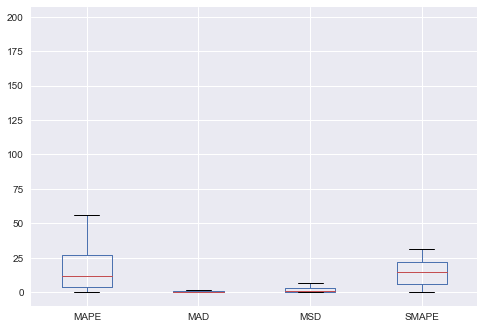

In [126]:
Perfor.boxplot(column=['MAPE','MAD','MSD','SMAPE'], by=None, ax=None, fontsize=None, rot=0, grid=True, figsize=None, layout=None)

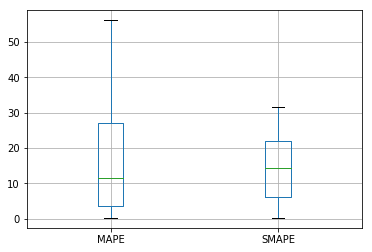

In [87]:
Perfor.boxplot(column=['MAPE','SMAPE'], by=None, ax=None, fontsize=None, rot=0, grid=True, figsize=None, layout=None)

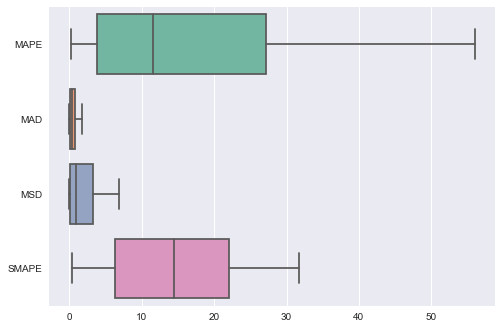

In [195]:
import seaborn as sns
sns.boxplot(data=Perfor, orient="h", palette="Set2",showfliers=False)


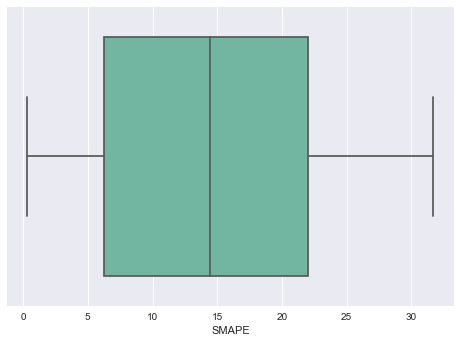

In [194]:

sns.boxplot(Perfor["SMAPE"],orient="h", palette="Set2")

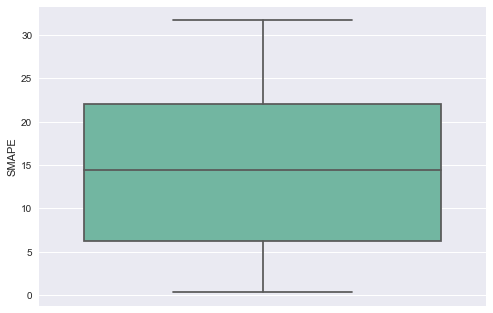

In [109]:
 sns.boxplot(Perfor["SMAPE"],orient="v", palette="Set2")

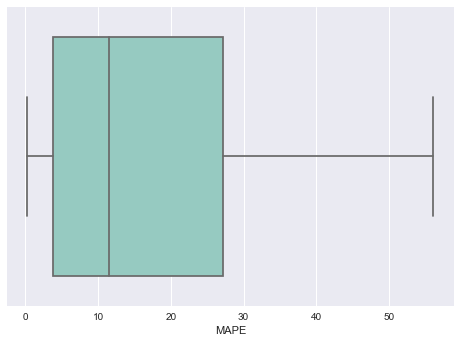

In [106]:
 sns.boxplot(Perfor["MAPE"],orient="h", palette="Set3")

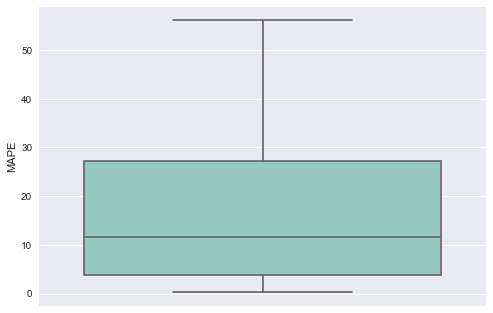

In [110]:
sns.boxplot(Perfor["MAPE"],orient="v", palette="Set3")

# 4-month ahead prediction 

In [196]:
#n_in: how much history we want 
n_in=20
dtt=series_to_supervised(dat,n_in,4)

In [197]:
dtt.head()

,var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var6(t-20),var7(t-20),var8(t-20),var9(t-20),var10(t-20),...,var54(t+3),var55(t+3),var56(t+3),var57(t+3),var58(t+3),var59(t+3),var60(t+3),var61(t+3),var62(t+3),var63(t+3)
20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
#first month prediction
def tspredict1(Products,data,nc):
   y=pd.DataFrame( data.loc[:,'var1(t)':'var1(t+1)'])
   X=data.iloc[:,:(n_in*len(Products))]
   c=centers(X,nc)
   r=radial(X,c)
   inputs= pd.DataFrame(RBF(c,r,X))
   inputs__arr=np.array(inputs)
   y__arr=np.array(y)
   prediction=[]
   performance=[]
   
   #m=MLPRegressor(activation='identity',alpha=0.05,learning_rate ='adaptive',verbose=False)
   #def baseline_model():
    # create model
   model = Sequential()
   model.add(Dense(1, input_dim=nc, kernel_initializer='normal'))
    # Compile model
   model.compile(loss='mean_squared_error', optimizer='sgd')
   for i in range(len(Products)):
        #mod=m.fit(inputs,y.iloc[:,i])
        model.fit(inputs__arr,y__arr[:,i], epochs=100, batch_size=20,verbose=0)
        pred=model.predict(inputs__arr)
        pred=np.squeeze(pred)
        ev=evaluate(y.iloc[:,i],pred)
        prediction.append(pred[len(pred)-1])
        performance.append(ev[3])
   #prediction=pd.DataFrame(prediction)
   return(prediction,performance)
pred1,Performance1=tspredict1(Products,dtt,80)


In [199]:
#second month prediction
def tspredict2(Products,data,nc):
   y=pd.DataFrame( data.loc[:,'var1(t+1)':'var1(t+2)'])
   X=data.iloc[:,:(n_in*len(Products))]
   c=centers(X,nc)
   r=radial(X,c)
   inputs= pd.DataFrame(RBF(c,r,X))
   inputs__arr=np.array(inputs)
   y__arr=np.array(y)
   prediction=[]
   performance=[]
   
   #m=MLPRegressor(activation='identity',alpha=0.05,learning_rate ='adaptive',verbose=False)
   #def baseline_model():
    # create model
   model = Sequential()
   model.add(Dense(1, input_dim=nc, kernel_initializer='normal'))
    # Compile model
   model.compile(loss='mean_squared_error', optimizer='sgd')
   for i in range(len(Products)):
        #mod=m.fit(inputs,y.iloc[:,i])
        model.fit(inputs__arr,y__arr[:,i], epochs=100, batch_size=20,verbose=0)
        pred=model.predict(inputs__arr)
        pred=np.squeeze(pred)
        ev=evaluate(y.iloc[:,i],pred)
        prediction.append(pred[len(pred)-1])
        performance.append(ev[3])
   #prediction=pd.DataFrame(prediction)
   return(prediction,performance)
pred2,Performance2=tspredict2(Products,dtt,80)


In [200]:
#third month prediction
def tspredict3(Products,data,nc):
   y=pd.DataFrame( data.loc[:,'var1(t+2)':'var1(t+3)'])
   X=data.iloc[:,:(n_in*len(Products))]
   c=centers(X,nc)
   r=radial(X,c)
   inputs= pd.DataFrame(RBF(c,r,X))
   inputs__arr=np.array(inputs)
   y__arr=np.array(y)
   prediction=[]
   performance=[]
   
   #m=MLPRegressor(activation='identity',alpha=0.05,learning_rate ='adaptive',verbose=False)
   #def baseline_model():
    # create model
   model = Sequential()
   model.add(Dense(1, input_dim=nc, kernel_initializer='normal'))
    # Compile model
   model.compile(loss='mean_squared_error', optimizer='sgd')
   for i in range(len(Products)):
        #mod=m.fit(inputs,y.iloc[:,i])
        model.fit(inputs__arr,y__arr[:,i], epochs=100, batch_size=20,verbose=0)
        pred=model.predict(inputs__arr)
        pred=np.squeeze(pred)
        ev=evaluate(y.iloc[:,i],pred)
        prediction.append(pred[len(pred)-1])
        performance.append(ev[3])
   #prediction=pd.DataFrame(prediction)
   return(prediction,performance)
pred3,Performance3=tspredict3(Products,dtt,80)


In [201]:
#forth month prediction
def tspredict4(Products,data,nc):
   y=pd.DataFrame( data.loc[:,'var1(t+3)':])
   X=data.iloc[:,:(n_in*len(Products))]
   c=centers(X,nc)
   r=radial(X,c)
   inputs= pd.DataFrame(RBF(c,r,X))
   inputs__arr=np.array(inputs)
   y__arr=np.array(y)
   prediction=[]
   performance=[]
   
   #m=MLPRegressor(activation='identity',alpha=0.05,learning_rate ='adaptive',verbose=False)
   #def baseline_model():
    # create model
   model = Sequential()
   model.add(Dense(1, input_dim=nc, kernel_initializer='normal'))
    # Compile model
   model.compile(loss='mean_squared_error', optimizer='sgd')
   for i in range(len(Products)):
        #mod=m.fit(inputs,y.iloc[:,i])
        model.fit(inputs__arr,y__arr[:,i], epochs=100, batch_size=20,verbose=0)
        pred=model.predict(inputs__arr)
        pred=np.squeeze(pred)
        ev=evaluate(y.iloc[:,i],pred)
        prediction.append(pred[len(pred)-1])
        performance.append(ev[3])
   
   return(prediction,performance)
pred4,Performance4=tspredict4(Products,dtt,80)


In [202]:
 #Grouping all predictions in one table
prediction=pd.DataFrame([pred1,pred2,pred3,pred4],columns=Products,index=["First month","Second month","Third month","Forth month"])
prediction[prediction<0]=0
prediction=prediction.transpose()
prediction

,First month,Second month,Third month,Forth month
"(9.32E+15,)",2.095340,2.154481,2.458914,1.773168
"(9.33E+15,)",45.101452,44.341286,41.637962,35.581127
"(9243015,)",1.409018,2.378509,0.469485,0.000000
"(9273011,)",0.000000,0.000000,0.000000,0.000000
"(9273021,)",0.000000,0.000000,0.000000,0.000000
"(9273031,)",0.000000,0.000000,0.000000,0.000000
"(9273051,)",0.000000,0.000000,0.000000,0.000000
"(9273052,)",0.000000,0.000000,0.000000,0.000000
"(9273121,)",0.662959,1.861852,1.416412,1.754224
"(9283021,)",0.000000,0.000000,0.000000,0.000000


In [203]:
 #Grouping the performance( SMAPE) for each product in the 4 months in one table
performance=pd.DataFrame([Performance1,Performance2,Performance3,Performance4],columns=Products,index=["First month SMAPE","Second month SMAPE","Third month SMAPE","Forth month SMAPE"])
performance=performance.transpose()
performance

,First month SMAPE,Second month SMAPE,Third month SMAPE,Forth month SMAPE
"(9.32E+15,)",21.726845,20.379861,20.136503,23.530724
"(9.33E+15,)",29.946870,32.234241,32.783357,33.318382
"(9243015,)",33.597444,32.398073,32.392872,35.704562
"(9273011,)",11.626137,10.868626,13.615908,13.636176
"(9273021,)",0.703023,1.270948,1.600000,1.600000
"(9273031,)",3.200000,3.200000,3.200000,3.200000
"(9273051,)",5.556166,5.970588,6.012590,6.024559
"(9273052,)",3.830786,3.460916,5.162447,5.410392
"(9273121,)",24.000323,23.696573,25.752026,25.406289
"(9283021,)",13.107689,14.953729,14.753647,15.243267


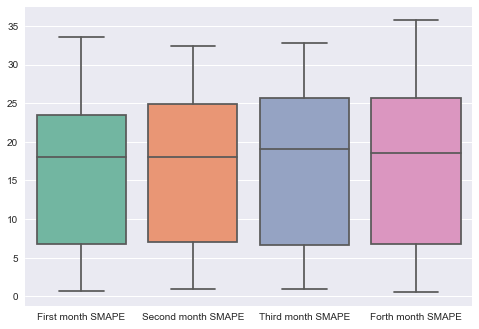

In [204]:
sns.boxplot(data=performance, orient="v", palette="Set2")

In [205]:
performance.describe()

,First month SMAPE,Second month SMAPE,Third month SMAPE,Forth month SMAPE
count,63.000000,63.000000,63.000000,63.000000
mean,15.653579,16.331963,16.675475,16.986350
std,9.560780,10.009197,10.317326,10.527748
min,0.703023,0.971799,0.943286,0.548758
25%,6.848914,7.053486,6.602764,6.753585
50%,18.059266,18.098764,19.111225,18.615126
75%,23.482583,24.885921,25.626496,25.607209
max,33.597444,32.398073,32.783357,35.704562
